In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from gymnasium import spaces
from torch.distributions import Categorical


In [2]:
import sys
sys.path.append("/home/martina/codi2/4year/tfg")  # add parent folder of general.py

from general import prepare, GlioblastomaPositionalEncoding


In [3]:
class CNNPolicy(nn.Module):
    def __init__(self, obs_shape, action_dim):
        """
        obs_shape: (C, H, W)
        action_dim: number of discrete actions
        """
        super().__init__()
        C, H, W = obs_shape

        self.conv = nn.Sequential(
            nn.Conv2d(C, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
        )

        # Dynamically compute the flatten size instead of hardcoding 64*5*5
        with torch.no_grad():
            dummy = torch.zeros(1, C, H, W)
            conv_out = self.conv(dummy)
            flat_dim = conv_out.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
        )

    def forward(self, x):
        """
        x: (B, C, H, W)
        returns: probs: (B, action_dim)
        """
        x = self.conv(x)
        x = x.flatten(1)
        logits = self.fc(x)
        probs = torch.softmax(logits, dim=-1)
        return probs

    def act(self, state, device):
        """
        state: np.array
          - (H, W)          for grayscale
          - (C, H, W)       for multi-channel (positional encoding)
        returns:
          action (int), log_prob (scalar tensor on `device`)
        """
        state_t = torch.as_tensor(state, dtype=torch.float32, device=device)

        if state_t.ndim == 2:        # (H, W) -> (1, 1, H, W)
            state_t = state_t.unsqueeze(0).unsqueeze(0)
        elif state_t.ndim == 3:      # (C, H, W) -> (1, C, H, W)
            state_t = state_t.unsqueeze(0)
        else:
            raise ValueError(f"Unexpected state ndim={state_t.ndim}, shape={state_t.shape}")

        probs = self.forward(state_t)           # (1, action_dim)
        dist = Categorical(probs)
        action = dist.sample()                  # (1,)
        log_prob = dist.log_prob(action)        # (1,)

        return action.item(), log_prob.squeeze(0)  # scalar tensor


In [4]:
class REINFORCEAgent:
    def __init__(self, env_class, train_pairs, env_config,
                 gamma=0.99, lr=1e-4, save_path="reinforce_policy.pt"):

        self.env_class = env_class
        self.train_pairs = train_pairs
        self.env_config = env_config
        self.gamma = gamma
        self.save_path = save_path

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # --- Infer observation shape & action_dim from a sample env ---
        sample_img, sample_mask = train_pairs[0]
        sample_env = env_class(sample_img, sample_mask, **env_config)
        obs, _ = sample_env.reset()

        if obs.ndim == 2:
            C, H, W = 1, obs.shape[0], obs.shape[1]
        elif obs.ndim == 3:
            C, H, W = obs.shape
        else:
            raise ValueError(f"Unexpected obs ndim={obs.ndim}, shape={obs.shape}")

        obs_shape = (C, H, W)
        self.action_dim = env_config["action_space"].n

        # --- Policy network ---
        self.policy = CNNPolicy(obs_shape, self.action_dim).to(self.device)
        self.model = self.policy  # for compatibility with your testing() function
        self.optim = optim.Adam(self.policy.parameters(), lr=lr)

        self.best_reward = -1e9

    def make_env(self, img_path, mask_path):
        return self.env_class(img_path, mask_path, **self.env_config)

    def run_episode(self, img_path, mask_path):
        """
        Runs one full episode on a single image/mask pair.
        Returns list of log_probs and list of rewards.
        """
        env = self.make_env(img_path, mask_path)

        log_probs = []
        rewards = []

        state, _ = env.reset()
        done = False

        while not done:
            action, log_prob = self.policy.act(state, self.device)
            next_state, reward, terminated, truncated, _ = env.step(action)

            log_probs.append(log_prob)
            rewards.append(reward)

            state = next_state
            done = terminated or truncated

        return log_probs, rewards

    def compute_returns(self, rewards):
        """
        Compute discounted returns G_t for a single episode (no normalization here).
        """
        G = 0.0
        returns = []
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        return returns  # plain Python list of floats

    def update_policy_batch(self, log_probs, returns):
        """
        log_probs: list of scalar tensors (already on device)
        returns:   1D tensor on device (same length as log_probs)
        """
        log_probs_t = torch.stack(log_probs)               # (N,)
        loss = -(log_probs_t * returns).sum()

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        return loss.item()
    
    def compute_log_probs_from_expert(self, states, actions):
        """
        Compute log_probs under current policy for expert actions.
        """

        log_probs = []
        for s, a in zip(states, actions):
            # s -> tensor
            state_t = torch.as_tensor(s, dtype=torch.float32, device=self.device)

            if state_t.ndim == 2:
                state_t = state_t.unsqueeze(0).unsqueeze(0)
            elif state_t.ndim == 3:
                state_t = state_t.unsqueeze(0)

            probs = self.policy(state_t)        # (1, A)
            dist = Categorical(probs)
            
            # Calculate log prob
            lp = dist.log_prob(torch.tensor(a, device=self.device))
            
            # --- FIX: Squeeze to make it a scalar () like in 'act' ---
            log_probs.append(lp.squeeze()) 

        return log_probs
    
    def expert_policy(self, env):
        # tumor centroid
        y, x = np.where(env.mask > 0)
        cy, cx = np.mean(y), np.mean(x)

        # current cell center
        gy = env.agent_pos[0] * env.block_size + env.block_size/2
        gx = env.agent_pos[1] * env.block_size + env.block_size/2

        # teacher picks the move that reduces distance the most
        moves = {
            1: (env.agent_pos[0] + 1, env.agent_pos[1]),  # down
            2: (env.agent_pos[0], env.agent_pos[1] + 1),  # right
            3: (env.agent_pos[0] - 1, env.agent_pos[1]),  # up
            4: (env.agent_pos[0], env.agent_pos[1] - 1),  # left
            0: (env.agent_pos[0], env.agent_pos[1])       # stay
        }

        best_action = 0
        best_dist = float("inf")

        for a, (ny, nx) in moves.items():
            if 0 <= ny < env.grid_size and 0 <= nx < env.grid_size:
                ncy = ny * env.block_size + env.block_size/2
                ncx = nx * env.block_size + env.block_size/2
                d = (ncx - cx)**2 + (ncy - cy)**2
                if d < best_dist:
                    best_dist = d
                    best_action = a

        # when in tumor → STAY
        if env.current_patch_overlap_with_lesion() > 0:
            return 0

        return best_action

    def run_human_episode(self, img_path, mask_path):
        states, actions, rewards = [], [], []

        env = self.make_env(img_path, mask_path)
        state, _ = env.reset(force_on_target=False, start_on_zero=False) # random start
        done = False

        found = False
        steps_to_tumor = None
        step = 0

        while not done:
            action = self.expert_policy(env)
            next_state, reward, term, trunc, _ = env.step(action)

            if env.current_patch_overlap_with_lesion() > 0 and not found:
                found = True
                steps_to_tumor = step
                
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state
            done = term or trunc
            step += 1
        
        return {
            "states": states,
            "actions": actions,
            "rewards": rewards,
            "found": found,
            "steps_to_tumor": steps_to_tumor,
            "episode_return": sum(rewards),
        }


    def train(self, epochs=200, expert_fraction=0.3):
        """
        One epoch = run 1 episode per train_pair, then do a single batch update
        using all (log_prob, G) pairs, with returns normalized across the epoch.
        """
        for e in range(1, epochs + 1):
            all_log_probs = []
            all_returns = []
            episode_returns = []  # sum of rewards per episode

            n_experts = int(len(self.train_pairs) * expert_fraction)
            print(n_experts, "expert episodes this epoch")
            
            expert_successes = 0
            expert_steps = []
            expert_returns = []
            
            # ---- Do expert ----
            for i in range(n_experts):
                img, mask = self.train_pairs[i]
                episode = self.run_human_episode(img, mask)
                
                if not episode["found"]:
                    print(f"WARNING: Expert failed on {img} — skipping this expert episode")
                    continue  # don't use bad expert episodes

                expert_successes += 1
                expert_steps.append(episode["steps_to_tumor"])
                expert_returns.append(episode["episode_return"])
                
                states = episode["states"]
                actions = episode["actions"]
                rewards = episode["rewards"]

                Gs = self.compute_returns(rewards)   # list of floats
                log_probs = self.compute_log_probs_from_expert(states, actions)
                
                all_log_probs.extend(log_probs)
                all_returns.extend(Gs)
                episode_returns.append(sum(rewards))
                
                print(f"    [Epoch {e} | Expert Episode {i}] "
                    f"Return={sum(rewards):.2f} (len={len(rewards)})")
                
            if expert_successes > 0:
                print(f"[Epoch {e}] Expert success rate: {expert_successes}/{n_experts}")
                print(f"[Epoch {e}] Avg expert steps to tumor: {np.mean(expert_steps):.2f}")
                print(f"[Epoch {e}] Avg expert return: {np.mean(expert_returns):.2f}")
            else:
                print(f"[Epoch {e}] No successful expert episodes this epoch!")

            # ---- Do normal ----
            for i, (img_path, mask_path) in enumerate(self.train_pairs):
                log_probs, rewards = self.run_episode(img_path, mask_path)

                Gs = self.compute_returns(rewards)   # list of floats
                all_log_probs.extend(log_probs)
                all_returns.extend(Gs)

                ep_ret = sum(rewards)
                episode_returns.append(ep_ret)

                if i % 10 == 0:
                    print(f"[Epoch {e} | Episode {i}] "
                          f"Return={ep_ret:.2f} (len={len(rewards)})")

            # ---- Normalize returns across the WHOLE epoch ----
            all_returns_t = torch.tensor(all_returns, dtype=torch.float32, device=self.device)
            all_returns_t = (all_returns_t - all_returns_t.mean()) / (all_returns_t.std() + 1e-8)

            # ---- Single policy update for the epoch ----
            loss = self.update_policy_batch(all_log_probs, all_returns_t)
            avg_ep_return = float(np.mean(episode_returns))

            # ---- Save best model ----
            if avg_ep_return > self.best_reward:
                self.best_reward = avg_ep_return
                torch.save(self.policy.state_dict(), self.save_path)
                print(f"  -> New best model saved ({self.save_path}), "
                      f"Avg return={avg_ep_return:.2f}")

            if e % 5 == 0 or e == 1:
                print(f"✅[Epoch {e}] Avg Return per Episode={avg_ep_return:.2f} | Loss={loss:.4f}")

        torch.save(self.policy.state_dict(), "reinforce_final.pt")
        print("Training finished. Final model saved to reinforce_final.pt")


In [11]:
CURRENT_CONFIG = {
    'grid_size': 6,
    'rewards': [20.0, -10.0, 2.5, -0.1], # [staying on tumor, staying off tumor, moving into tumor, movement cost] #[3.0, -1.0, -0.2],
    'action_space': spaces.Discrete(5), 
    'max_steps': 20
    # 'stop': False
}

train_pairs = prepare(dataset=200)


Using dataset of 200 samples for training.
✅ Found 200 pairs out of 200 listed in CSV.


In [12]:
agent = REINFORCEAgent(
    env_class=GlioblastomaPositionalEncoding,
    train_pairs=train_pairs,
    env_config=CURRENT_CONFIG,
    gamma=0.99,
    lr=1e-4,
    save_path="reinforce_best.pt"
)

agent.train(epochs=200, expert_fraction=0.6)


120 expert episodes this epoch
    [Epoch 1 | Expert Episode 0] Return=22.50 (len=2)
    [Epoch 1 | Expert Episode 1] Return=22.30 (len=4)
    [Epoch 1 | Expert Episode 2] Return=22.40 (len=5)
    [Epoch 1 | Expert Episode 3] Return=-10.24 (len=2)
    [Epoch 1 | Expert Episode 4] Return=-10.23 (len=2)
    [Epoch 1 | Expert Episode 5] Return=-10.27 (len=2)
    [Epoch 1 | Expert Episode 6] Return=-10.00 (len=2)
    [Epoch 1 | Expert Episode 7] Return=-10.00 (len=1)
    [Epoch 1 | Expert Episode 8] Return=-10.26 (len=2)
    [Epoch 1 | Expert Episode 9] Return=22.10 (len=5)
    [Epoch 1 | Expert Episode 10] Return=-10.24 (len=2)
    [Epoch 1 | Expert Episode 11] Return=-9.92 (len=3)
    [Epoch 1 | Expert Episode 12] Return=20.00 (len=1)
    [Epoch 1 | Expert Episode 13] Return=-10.48 (len=3)
    [Epoch 1 | Expert Episode 14] Return=-10.00 (len=1)
    [Epoch 1 | Expert Episode 15] Return=22.35 (len=5)
    [Epoch 1 | Expert Episode 16] Return=22.32 (len=4)
    [Epoch 1 | Expert Episode 17] R

# see the human episode:

In [16]:
# see how one human episode will look like
single_pair = train_pairs[:5]
print(single_pair)

[('/home/martina/codi2/4year/tfg/training_set_200_npy/002_54.npy', '/home/martina/codi2/4year/tfg/training_set_200_npy/002_54_mask.npy'), ('/home/martina/codi2/4year/tfg/training_set_200_npy/004_98.npy', '/home/martina/codi2/4year/tfg/training_set_200_npy/004_98_mask.npy'), ('/home/martina/codi2/4year/tfg/training_set_200_npy/008_40.npy', '/home/martina/codi2/4year/tfg/training_set_200_npy/008_40_mask.npy'), ('/home/martina/codi2/4year/tfg/training_set_200_npy/011_55.npy', '/home/martina/codi2/4year/tfg/training_set_200_npy/011_55_mask.npy'), ('/home/martina/codi2/4year/tfg/training_set_200_npy/011_67.npy', '/home/martina/codi2/4year/tfg/training_set_200_npy/011_67_mask.npy')]


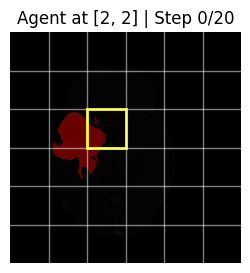

Step: 0 Action: 0
Episode finished, action is 0, tumor found: True


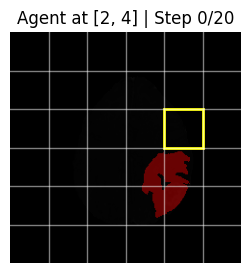

Step: 0 Action: 1


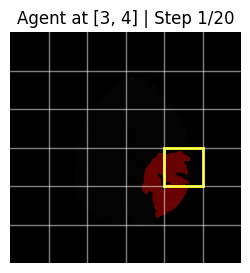

Step: 1 Action: 0
Episode finished, action is 0, tumor found: True


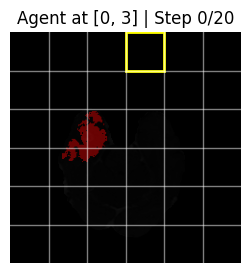

Step: 0 Action: 1


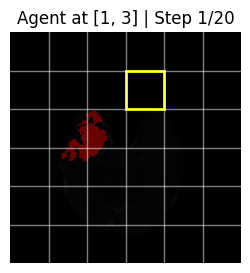

Step: 1 Action: 4


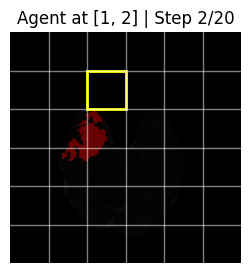

Step: 2 Action: 1


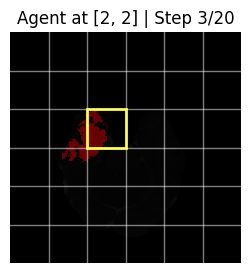

Step: 3 Action: 0
Episode finished, action is 0, tumor found: True


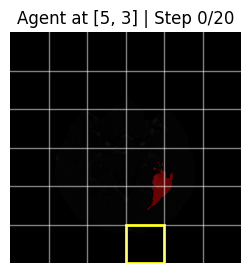

Step: 0 Action: 3


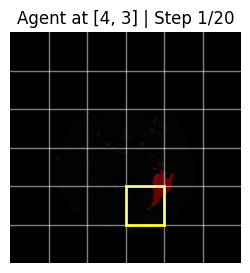

Step: 1 Action: 0
Episode finished, action is 0, tumor found: True


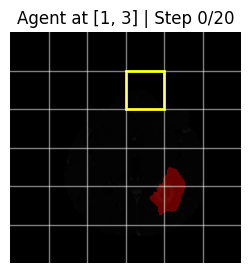

Step: 0 Action: 1


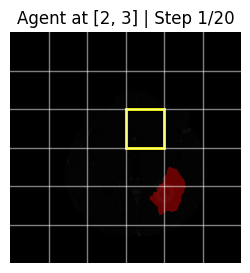

Step: 1 Action: 1


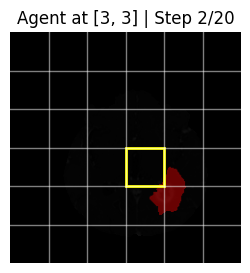

Step: 2 Action: 0
Episode finished, action is 0, tumor found: True


In [18]:
def run_human_episode(self, img_path, mask_path):
        states, actions, rewards = [], [], []

        env = self.make_env(img_path, mask_path)
        state, _ = env.reset(force_on_target=False, start_on_zero=False) # random start
        done = False

        found = False
        steps_to_tumor = None
        step = 0

        while not done:
            action = self.expert_policy(env)
            env.render(show=True)
            print("Step:", step, "Action:", action)
            next_state, reward, term, trunc, _ = env.step(action)

            if env.current_patch_overlap_with_lesion() > 0 and not found:
                found = True
                steps_to_tumor = step
                
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state
            done = term or trunc
            if done:
                print(f"Episode finished, action is {action}, tumor found: {found}")
            step += 1
        
        return {
            "states": states,
            "actions": actions,
            "rewards": rewards,
            "found": found,
            "steps_to_tumor": steps_to_tumor,
            "episode_return": sum(rewards),
        }
for pair in single_pair:
    game = run_human_episode(agent, pair[0], pair[1])